In [1]:
# 如果pandas没有被安装，请取消下一句的注释。
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l


In [2]:
train_data = pd.read_csv(d2l.download('kaggle_house_train'))
test_data = pd.read_csv(d2l.download('kaggle_house_test'))

In [3]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [4]:
# 得到数值特征的index序列
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())) # 特征具有零均值和单位方差
# 将NA定义为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [5]:
# one-hot coding,并将NA视为有效的特征值
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [6]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[0:n_train].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape((-1, 1)), dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)

In [7]:
# 定义损失函数和模型
loss = nn.MSELoss()
in_features = train_features.shape[1]
def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

In [8]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [9]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features,train_labels), batch_size)
    optimzer = torch.optim.Adam(net.parameters(), lr = learning_rate, weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimzer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimzer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [10]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j*fold_size, (j + 1)*fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [11]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

fold 1, train log rmse 0.170477, valid log rmse 0.157208
fold 2, train log rmse 0.162202, valid log rmse 0.192706
fold 3, train log rmse 0.163585, valid log rmse 0.168163
fold 4, train log rmse 0.168491, valid log rmse 0.154795
fold 5, train log rmse 0.164063, valid log rmse 0.183350
5-折验证: 平均训练log rmse: 0.165764, 平均验证log rmse: 0.171244


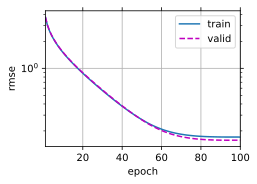

In [12]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')